In [1]:
%load_ext autoreload
%autoreload 2
# %matplotlib notebook

from utils import *
import sys
sys.path.append('/Users/theoares/lqcd/utilities')
from plottools import *
from scipy.integrate import quad

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['/Users/theoares/Library/Fonts/cmunrm.otf'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


## Initialize parameters and Laplace kernel

#### Sparse modeling

This notebook uses principles of sparse modeling to reconstruct a spectral function $\rho(\omega)$ from finite Green's function data $G(\tau)$. $G$ is constructed from the spectral function by a Laplace transform,
$$
    G(\tau) = \int_\mathbb{R} d\omega\, e^{-\omega\tau}\rho(\omega).
$$
This method will discretize the Laplace transform to write it as a matrix equation. The Green's function $G(\tau)$ is evaluated at discrete $\{\tau_i\}$ of size $N_\tau$, and the spectral function is evaluated at discrete $\{\omega_j\}$ of size $N_\omega$, and the discretized vectors are $\mathbf G_i = G(\tau_i)$ and $\mathbf \rho_j = \rho(\omega_j)$. In this form, the previous equation becomes a matrix equation,
$$
    \mathbf{G}_i = K_{ij} \mathbf{\rho}_j,
$$
where $K_{ij} = e^{-\tau_i \omega_j}$ is the discretized Laplace kernel, a matrix of size $N_\tau\times N_\omega$. 

The approach we will take to solving this problem is to exploit the sparsity of $\rho(\omega)$ in a so-called "Intermediate Representation (IR)". An IR is defined by performing a singular value decomposition of $K_{ij}$:
$$
    K = U S V^\dagger,
$$
where $U, V$ are respectively unitary $N_\tau\times N_\tau$ and $N_\omega\times N_\omega$ matrices, and S is the diagonal matrix of singular values. The IR specific to $K$ (as we will have different representations depending on the dimension of $U$ and $V$) is defined as a rotation of $\mathbf G$ and $\mathbf \rho$ by the corresponding unitary matrices $U$ and $V^\dagger$:
\begin{align}
    \mathbf G' = U^\dagger \mathbf G && \mathbf \rho' = V^\dagger \mathbf \rho.
\end{align}
In this representation the components of $\mathbf G'$ and $\mathbf \rho'$ are related by multiplication with a singular value $s_\ell\equiv S_{\ell\ell}$ (note here there is no sum on $\ell$):
$$
    \mathbf G'_\ell = s_\ell \mathbf \rho'_\ell.
$$

In this representation, the spectral function is \textbf{sparse}, meaning that it has a large number of components which are zero or very close to 0. We can exploit the sparsity to solve the Least Absolute Shrinkage and Selection Operator (LASSO) problem, which is the optimization problem which corresponds to the minimization of the following function,
$$
    F_{LASSO}(\mathbf x) = \frac{1}{2} ||\mathbf G - K \mathbf x||_2^2 + \lambda ||\mathbf x||_1,
$$
where $||\cdot||_p$ is the $L^p$ norm and $\lambda$ is a \textbf{hyperparameter}, meaning that it is chosen and tweaked by the user to find the best solution to the inverse problem. The $L_1$ norm term is interpreted as a penalty; the optimization searches through the space of $\mathbf x$ and tries to minimize the objective function $|| \mathbf G - K\mathbf x||_2^2$, subject to also trying to minimize $||\mathbf x||_1$. If $\lambda$ is small, minimization of the objective function is most important; however if $\lambda$ is large, minimization of the $L_1$ norm is more important, and so the choise of $\lambda$ is a choice between getting the closest solution to the input data and having a solution which is sparse. 

Note that in our problem, we want to perform the minimization subject to the sparsity of $\mathbf{\rho}'$, the components of $\mathbf \rho$ in an IR. That is, we solve for $\mathbf{\rho}'$ in the following optimization problem:
$$
    \mathbf{\rho'} = \arg\min_\mathbf{\rho'} \left[\frac{1}{2}|| \mathbf{G}' - S \mathbf{\rho}' ||_2^2 + \lambda ||\mathbf{\rho}'||_1\right]
$$
and then rotate back to $\mathbf{\rho} = V \mathbf{\rho}'$ afterward.

In [2]:
Ntau = 16
# Nomega = 32
Nomega = 64
taus = np.arange(Ntau)

# omega_line is the omega linspace that rho is simulated on. 
omega_line = np.linspace(0, 2, Nomega)    # to simulate spectral function on
DelOmega = (omega_line[-1] - omega_line[0]) / Nomega

# # omegas is the linspace that the recon for rho is performed on. It doesn't have to be the same as omega_line
# omega_bounds = [0, 2]
# domega = 0.01
# omegas = np.arange(omega_bounds[0], omega_bounds[1], domega)
omegas = omega_line                    # to use for recon

In [3]:
kernel = laplace_kernel(taus, omegas)
U, svals, Vdag = np.linalg.svd(kernel)
V = hc(Vdag)
S = np.pad(np.diag(svals), [(0, 0), (0, len(omegas) - len(taus))])

In [4]:
# SVD sanity checks
print(check_mat_equal(U @ hc(U), np.eye(len(U))))
print(check_mat_equal(V @ Vdag, np.eye(len(Vdag))))
print(check_mat_equal(U @ S @ Vdag, kernel))

(True, 6.661338147750939e-16)
(True, 6.661338147750939e-16)
(True, 1.9984014443252818e-15)


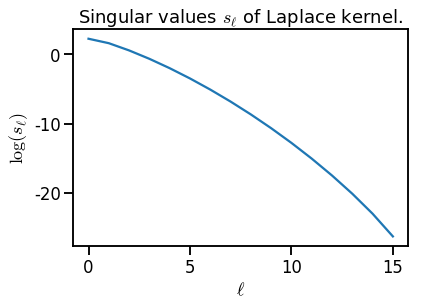

In [5]:
# The area where the singular values asymptote is likely machine precision. 
with sns.plotting_context('talk'):
    plt.figure()
    plt.plot(np.log(svals))
    plt.xlabel('$\ell$')
    plt.ylabel('$\log(s_\ell)$')
    plt.title('Singular values $s_\ell$ of Laplace kernel.')
    plt.show()

In [6]:
# # simulate a spectral function which is known to be sparse in IR
# rhop_supp = np.arange(20, 30)
# rhop_sim = np.zeros((Nomega), dtype = np.float64)
# rhop_sim[rhop_supp] = 1.
# rho_sim = V @ rhop_sim
# G = kernel @ rho_sim

In [7]:
# with sns.plotting_context('talk'):
#     fig, ax = plt.subplots(1, 2, figsize = (15, 5))
#     plot_1d_function(ax[0], omega_line, rhop_sim, title = 'ρ\' in sparse basis', ax_label = ['ω', 'ρ'], \
#                      legend = False, colors = ['c'])
#     plot_1d_function(ax[1], omega_line, rho_sim, title = 'ρ = V ρ\' in regular basis', ax_label = ['ω', 'ρ'], \
#                      legend = False, colors = ['r'])
#     plt.tight_layout()

In [8]:
# Two types of spectral fns to simulate
omega0 = 0.8
delOmega = 0.3
def rho(omega):
    return np.exp(- (omega - omega0) ** 2 / (2 * (delOmega ** 2))) / (np.sqrt(2 * np.pi) * delOmega)# * DelOmega

# omega_supp = [0.8, 1.1]
# rho = lambda omega : 1 / (omega_supp[1] - omega_supp[0]) if omega > omega_supp[0] and omega < omega_supp[1] else 0

# def signal(tau):
#     integrand = lambda omega : np.exp(-omega * tau) * rho(omega)
#     return quad(integrand, 0, np.inf)[0]
rho_dat = np.array([rho(a) * DelOmega for a in omega_line])
rhop_dat = Vdag @ rho_dat

np.random.seed(10)
# G = np.array([signal(t) for t in taus])
G = kernel @ rho_dat
print('Evaluating Greens function at tau = it = ' + str(taus))
# print('Sum of ρ_i Δω = ' + str(np.sum(rho_dat) * DelOmega))
print('Sum of ρ_i = ' + str(np.sum(rho_dat)))

Evaluating Greens function at tau = it = [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Sum of ρ_i = 0.9811454199778095


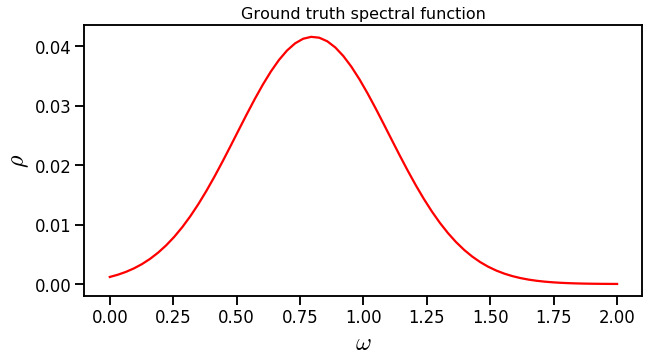

In [9]:
with sns.plotting_context('talk'):
    fig, ax = plt.subplots(1, figsize = (10, 5))
    plot_1d_function(ax, omega_line, rho_dat, colors = 'r', title = 'Ground truth spectral function', \
                     ax_label = ['$\\omega$', '$\\rho$'], legend = False)
#     plt.tight_layout()
#     plt.savefig('/Users/theoares/Dropbox (MIT)/research/spectral/sparse_modeling/tests/test1/ground_truth_spectral.pdf')

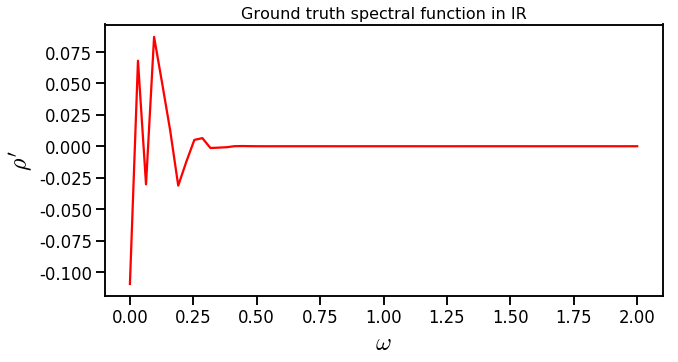

In [10]:
with sns.plotting_context('talk'):
    fig, ax = plt.subplots(1, figsize = (10, 5))
    plot_1d_function(ax, omega_line, rhop_dat, colors = 'r', title = 'Ground truth spectral function in IR', \
                     ax_label = ['$\\omega$', '$\\rho\'$'], legend = False)

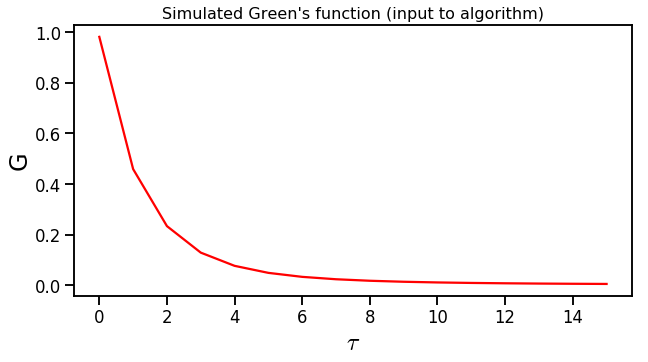

In [11]:
with sns.plotting_context('talk'):
    fig, ax = plt.subplots(1, figsize = (10, 5))
    plot_1d_function(ax, taus, G, colors = 'r', title = 'Simulated Green\'s function (input to algorithm)', ax_label = ['$\\tau$', 'G'], \
                     legend = False)

## Solve inverse problem with ADMM

#### ADMM parameters

The Alternating Direction Method of Multipliers (ADMM) is an algorithm which solves the LASSO problem. The idea is to impose constraints by adding terms to the minimization problem. This is performed by adding in auxiliary variables to the optimization problem and minimizing / maximizing them all jointly. The basic setup is a bit more lenient than the optimization problem we already have, in which we want to jointly minimize the following equation:
$$
    f(\mathbf x) + g(\mathbf z)\; \mathrm{s.t.}\; A\mathbf x + B\mathbf z = \mathbf c
$$
Here $g$ is non-differentiable and will be taken to be the regularizing term. In ADMM, we form the (scaled) augmented Lagrangian to incorporate the constraint, which adds it in as a part of the optimization rather than doing a projection onto the space which satisfies the constraint:
$$
    L_\rho(\mathbf x, \mathbf y, \mathbf z) = f(\mathbf x) + g(\mathbf z) + \frac{1}{2}\rho || A\mathbf x + B\mathbf z - \mathbf c||_2^2 + \rho \mathbf y^T (A\mathbf x + B\mathbf z - \mathbf c)
$$
where here $\rho$ is a parameter and $\mathbf y$ is a Lagrange multiplier. Each constraint that one enforces in the optimization will add an extra parameter $\rho'$ and Lagrange multiplier $\mathbf y'$, added to the augmented Lagrangian in the same way. 

The idea is that you solve this Lagrangian with an optimization technique similar to dual ascent (which maximizes a dual problem to find the equivalent solution to the optimization), by iteratively performing the following sequence of maximizations / minimizations on the augmented Lagrangian:
$$
    \mathrm{maximize}_\mathbf{y} \; \mathrm{minimize}_{\mathbf z} \; \mathrm{minimize}_{\mathbf x} \; L_\rho(\mathbf x, \mathbf y, \mathbf z).
$$
The "alternating" part of the name comes from this, because you solve the $\vec x$ minimization first, then the $\vec z$ minimization, and finally maximize $\mathbf y$-- the optimization occurs over alternating directions. From iteratively performing this minimization / maximization, the primal variables $\mathbf x$ and $\mathbf z$ will converge to their optimal values.

#### ADMM updates

The ADMM algorithm proceeds by performing the minimizations and maximizations of the augmented Lagrangian:
- Minimize $\mathbf x$. This can be done by simply differentiating the functional with respect to $\mathbf x$ and setting the derivative to $\mathbf 0$.  
- Minimize $\mathbf z$.
- Maximize $\mathbf y$. 

#### Convergence

TODO edit this

Some terminology: $\vec x$ and $\vec z$ are called the \textbf{primal variables}, and $\vec y$ (or the scale version $\vec u = \vec y / \rho$) is called the \textbf{dual variable}. You get an additional dual variable for each constract that you impose on the system. There are a few different residuals that you can consider in this problem. The obvious one is the \textbf{primal residual}:
$$
    r^k = f(\mathbf x^k) + g(\mathbf z^k)
$$
which measures how close to zero the objective function that you're minimizing is. In our case, the primal residual takes the form:
$$
    r^k = ||\mathbf G'^k - S \mathbf\rho'^k||_2^2 + \lambda ||\mathbf\rho'^k||_1
$$
You can also consider the \textbf{dual residual}, which measures how close the constraints are to being satisfied:
$$
    d^k = ||A\mathbf x^k + B\mathbf z^k - \mathbf c||_2^2
$$

#### Application to our problem

TODO edit this section, some things are not written out well

For our problem, we need to split up the optimization into the form $f(\vec \rho') + g(\vec z')$, and we have two constraints: non-negativity and the sum rule. We need to add in a bunch of auxiliary variables consistent with the previous cell to deal with these. The variables which are added in are:
- $\vec z'$, which converges to $\rho'$. This is added to give the optimization problem the correct form. The additional constraint to enforce is:
$$
    \vec z' = \vec \rho'
$$
- $\vec z$, which converges to the original $\vec\rho$. The additional constraint to enforce is:
$$
    \vec z = V \vec\rho'
$$
To enforce these constraints, additional hyperparameters $\mu$ and $\mu'$ are added in, as well as scaled Lagrange multipliers $\vec u$ and $\vec u'$. 
- $\mu$ and $\vec u$: These enforce the constraint $\vec z = V\vec \rho'$. This is added to the augmented Lagrangian (the function to min / max over) as:
$$
    \frac{1}{2}\mu ||\vec z - V\vec \rho' ||_2^2 + \vec u^T (\vec z - V\vec\rho')
$$
- $\mu'$ and $\vec u'$: These enforce the constraint $\vec z' = \vec \rho'$, and $\mu'$ controls the speed of convergence (not sure why at the moment). The following term is added to the augmented Lagrangian:
$$
    \frac{1}{2} \mu' ||\vec z' - \vec\rho' ||_2^2 + \vec u'^T (\vec z - \vec \rho')
$$

In [12]:
# initialize parameters. Here we'll use the default settings.
params = ADMMParams.default_params(Nomega, d = (Ntau, Nomega))
params.lam = 1e-5
params.mu = 1e-5
params.mup = 1e-5
# params.lam = 1e-4
# params.mu = 1.
# params.mup = 1e-4
params.max_iters = 10000
params.eps = 1e-5

In [13]:
rho_recon, xp, primal_resid, dual_resid, iters = \
            admm(G, taus, omegas, params, disp_iters = 1000)
#            admm(G, taus, omegas, params, resid_norm = lpnorm(1), disp_iters = 1000)

Starting solver.
Iteration 1000: primal residual = 0.01885462206348571, dual resid = 0.036202219209224853, elapsed time = 0.1448829174041748
Iteration 2000: primal residual = 0.018854631990484722, dual resid = 0.03167716550186206, elapsed time = 0.27280688285827637
Iteration 3000: primal residual = 0.01885464379338176, dual resid = 0.028272749055490997, elapsed time = 0.4010128974914551
Iteration 4000: primal residual = 0.018854658019152995, dual resid = 0.025286636147025324, elapsed time = 0.5357677936553955
Iteration 5000: primal residual = 0.01885467384983281, dual resid = 0.022672017687109507, elapsed time = 0.6676108837127686
Iteration 6000: primal residual = 0.01885469062026111, dual resid = 0.02040412379563388, elapsed time = 0.7893667221069336
Iteration 7000: primal residual = 0.018854707822539837, dual resid = 0.018461097841165664, elapsed time = 0.9274349212646484
Iteration 8000: primal residual = 0.0188547251371884, dual resid = 0.01689739576950509, elapsed time = 1.05367565

(-0.002388419210276977, 0.05015680341581651)


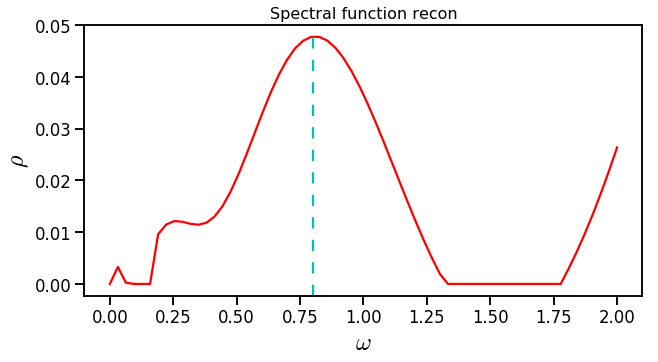

In [14]:
# currently normalized so that sum_i rho_i = 1, but we want sum_i Delta\omega = 1
with sns.plotting_context('talk'):
    fig, ax = plt.subplots(1, figsize = (10, 5))
    plot_1d_function(ax, omegas, rho_recon, colors = 'r', title = 'Spectral function recon', \
                     ax_label = ['$\\omega$', '$\\rho$'], legend = False)
    print(ax.get_ylim())
    add_line(ax, omega0, color = 'c', dashes = (5, 5), label = '$\\omega_0$')

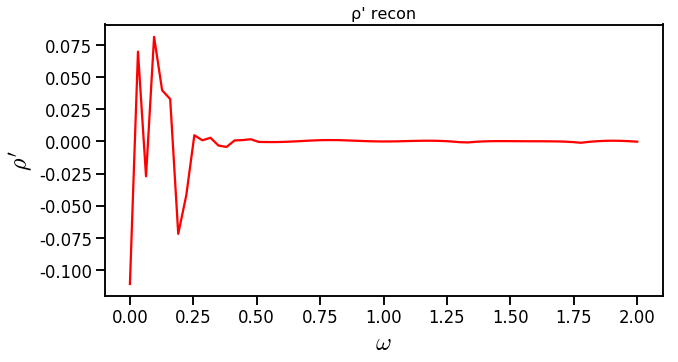

In [15]:
# looks close to the original
with sns.plotting_context('talk'):
    fig, ax = plt.subplots(1, figsize = (10, 5))
    plot_1d_function(ax, omegas, xp, colors = 'r', title = 'ρ\' recon', \
                     ax_label = ['$\\omega$', '$\\rho\'$'], legend = False)

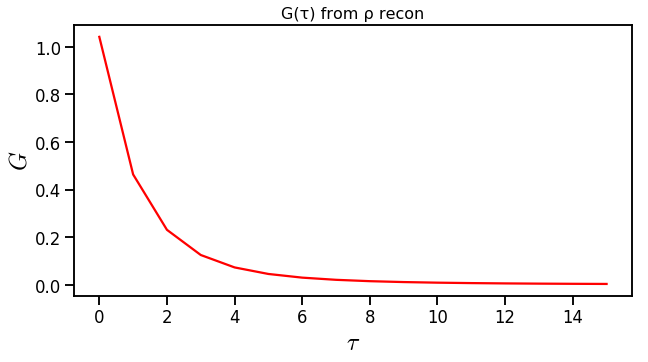

In [16]:
# looks close to the original, but the scale is absolutely off
Grecon = kernel @ rho_recon
with sns.plotting_context('talk'):
    fig, ax = plt.subplots(1, figsize = (10, 5))
    plot_1d_function(ax, taus, Grecon, colors = 'r', title = 'G(τ) from ρ recon', \
                     ax_label = ['$\\tau$', '$G$'], legend = False)

#### Scan the parameter range

The hyperparameters $(\lambda, \mu, \mu')$ are inputs to the optimization problem and can be tuned. As a result, the reconstruction $\mathbf \rho$ depends on each of these input parameters, i.e. $\mathbf \rho = \mathbf\rho(\lambda, \mu, \mu')$, and changing each hyperparameter may change the general structure of the reconstruction. As a rule of thumb, the range of possible hyperparameters should be scanned over to see what yields the "best" reconstruction. Once this is properly tested and worked with, this part could be done in parallel, since we're just performing the same computation and looping over the input parameters.  

Defining "best" requires some work, especially when we're doing this in practice (and not in simulation) and don't know what the ground truth $\mathbf \rho$ should look like. The easiest way to do this is to define a fidelity function Fid:
$$
    \mathrm{Fid} : \{\mathbf \rho(\lambda, \mu, \mu')\}\rightarrow \mathbb{R}
$$
which tells us how "good" the reconstruction is. The better the reconstruction, the closer the fidelity metric is to 0, so at the end of the day we can find the best hyperparameters by minimizing Fid:
$$
    (\lambda^*, \mu^*, \mu'^*) = \arg\min_{\lambda, \mu, \mu'} \mathrm{Fid}(\mathbf\rho(\lambda, \mu, \mu'))
$$

The fidelity function I'm currently using is simply the distance between the output Green's function from $\mathbf \rho$ and the actual measured Green's function:
$$
    \mathrm{Fid}(\mathbf \rho) = ||\mathbf G - K\mathbf \rho ||_2^2
$$
but this does not always give the best result, simply because the problem is underdetermined (it's also strangely close for a lot of the reconds, so I think there's something up). 

Some extra terms I'd like to add to the fidelity function: 
- Use input from correlator fits to specify that there should be a "peak" in the spectral function around its ground state at $\omega_0$, and no peak before that. I need to design a specific functional form for that as well, and I'd like to add that as a constraint in the actual algorithm too. 
- Some form of smoothness prior to prevent rapid oscillations. 

In [17]:
# lam_list = [10 ** n for n in np.arange(-8, 1., 2.)]
lam_list = [10 ** n for n in np.arange(-5, 1., 1.)]
mu_list = lam_list
mup_list = lam_list
max_iters = 10000
# max_iters = 50000
rho_recons, p_resids, d_resids = parameter_scan(G, taus, omegas, lam_list, mu_list, mup_list, max_iters)

(lambda, mu, mup) = (1e-05, 1e-05, 1e-05)
Starting solver.
Iteration 1000: primal residual = 0.01885462206348571, dual resid = 0.036202219209224853, elapsed time = 0.1509089469909668
Iteration 2000: primal residual = 0.018854631990484722, dual resid = 0.03167716550186206, elapsed time = 0.28991007804870605
Iteration 3000: primal residual = 0.01885464379338176, dual resid = 0.028272749055490997, elapsed time = 0.45547914505004883
Iteration 4000: primal residual = 0.018854658019152995, dual resid = 0.025286636147025324, elapsed time = 0.6133661270141602
Iteration 5000: primal residual = 0.01885467384983281, dual resid = 0.022672017687109507, elapsed time = 0.7580349445343018
Iteration 6000: primal residual = 0.01885469062026111, dual resid = 0.02040412379563388, elapsed time = 0.9054560661315918
Iteration 7000: primal residual = 0.018854707822539837, dual resid = 0.018461097841165664, elapsed time = 1.054738998413086
Iteration 8000: primal residual = 0.0188547251371884, dual resid = 0.01

Iteration 8000: primal residual = 0.018863596968615035, dual resid = 0.004533614950354304, elapsed time = 1.1023688316345215
Iteration 9000: primal residual = 0.018863597019867714, dual resid = 0.004533594697130266, elapsed time = 1.2394747734069824
Iteration 10000: primal residual = 0.018863597071120244, dual resid = 0.00453357444463472, elapsed time = 1.3733818531036377
Run complete. 
   Iterations: 10000
   Primal residual: 0.018863597071120244
   Dual residual: 0.00453357444463472
   Elapsed time: 1.3735039234161377
(lambda, mu, mup) = (1e-05, 0.0001, 1e-05)
Starting solver.
Iteration 1000: primal residual = 0.018854635130542467, dual resid = 0.018070553574366006, elapsed time = 0.13329291343688965
Iteration 2000: primal residual = 0.018854655415067135, dual resid = 0.013962577523473995, elapsed time = 0.2803058624267578
Iteration 3000: primal residual = 0.01885467991815828, dual resid = 0.010617124738179528, elapsed time = 0.41100096702575684
Iteration 4000: primal residual = 0.01

Iteration 4000: primal residual = 0.018863598586899913, dual resid = 0.004532824295793893, elapsed time = 0.529543399810791
Iteration 5000: primal residual = 0.018863599099192288, dual resid = 0.00453262203071675, elapsed time = 0.6628260612487793
Iteration 6000: primal residual = 0.018863599611420832, dual resid = 0.0045324198383965885, elapsed time = 0.8041872978210449
Iteration 7000: primal residual = 0.018863600123585934, dual resid = 0.004532217718803533, elapsed time = 0.9397592544555664
Iteration 8000: primal residual = 0.01886360063568763, dual resid = 0.004532015671908029, elapsed time = 1.0743601322174072
Iteration 9000: primal residual = 0.01886360114772569, dual resid = 0.004531813697680381, elapsed time = 1.2072393894195557
Iteration 10000: primal residual = 0.018863601659700215, dual resid = 0.004531611796091204, elapsed time = 1.3404343128204346
Run complete. 
   Iterations: 10000
   Primal residual: 0.018863601659700215
   Dual residual: 0.004531611796091204
   Elapsed 

Iteration 2000: primal residual = 0.018863606560169083, dual resid = 0.0045281689294030345, elapsed time = 0.2637758255004883
Iteration 3000: primal residual = 0.018863611669482628, dual resid = 0.004526161259067412, elapsed time = 0.3976302146911621
Iteration 4000: primal residual = 0.018863616772442506, dual resid = 0.004524160786741999, elapsed time = 0.5304169654846191
Iteration 5000: primal residual = 0.018863621869046953, dual resid = 0.004522167483173369, elapsed time = 0.6641740798950195
Iteration 6000: primal residual = 0.018863626959293955, dual resid = 0.004520181319209695, elapsed time = 0.7983829975128174
Iteration 7000: primal residual = 0.018863632043181245, dual resid = 0.004518202265801307, elapsed time = 0.935291051864624
Iteration 8000: primal residual = 0.018863637120707637, dual resid = 0.004516230293999977, elapsed time = 1.0738821029663086
Iteration 9000: primal residual = 0.018863642191870828, dual resid = 0.004514265374958656, elapsed time = 1.2074511051177979


Iteration 10000: primal residual = 0.018864051101751603, dual resid = 0.004215088689602918, elapsed time = 1.4539930820465088
Run complete. 
   Iterations: 10000
   Primal residual: 0.018864051101751603
   Dual residual: 0.004215088689602918
   Elapsed time: 1.454138994216919
(lambda, mu, mup) = (1e-05, 0.01, 1.0)
Starting solver.
Iteration 1000: primal residual = 0.018863645064956202, dual resid = 0.00449814498968445, elapsed time = 0.14181208610534668
Iteration 2000: primal residual = 0.0188636953093021, dual resid = 0.004478953948551013, elapsed time = 0.28795909881591797
Iteration 3000: primal residual = 0.018863744919791425, dual resid = 0.004460430982487882, elapsed time = 0.4228219985961914
Iteration 4000: primal residual = 0.01886379389617666, dual resid = 0.004442549270882146, elapsed time = 0.5663461685180664
Iteration 5000: primal residual = 0.01886384223901192, dual resid = 0.004425282937373132, elapsed time = 0.7088220119476318
Iteration 6000: primal residual = 0.018863889

Iteration 10000: primal residual = 0.01886484902116804, dual resid = 0.0013645414570118866, elapsed time = 1.3481359481811523
Run complete. 
   Iterations: 10000
   Primal residual: 0.01886484902116804
   Dual residual: 0.0013645414570118866
   Elapsed time: 1.3482739925384521
(lambda, mu, mup) = (1e-05, 1.0, 1e-05)
Starting solver.
Run complete. 
   Iterations: 273
   Primal residual: 0.018854647372988014
   Dual residual: 9.969336277279901e-06
   Elapsed time: 0.03762674331665039
(lambda, mu, mup) = (1e-05, 1.0, 0.0001)
Starting solver.
Run complete. 
   Iterations: 413
   Primal residual: 0.01885477548609284
   Dual residual: 9.975346717686327e-06
   Elapsed time: 0.060858964920043945
(lambda, mu, mup) = (1e-05, 1.0, 0.001)
Starting solver.
Iteration 1000: primal residual = 0.018855348928393453, dual resid = 1.7946675470224378e-05, elapsed time = 0.13603687286376953
Run complete. 
   Iterations: 1943
   Primal residual: 0.01885597580051678
   Dual residual: 9.425709537794237e-06
   

Iteration 1000: primal residual = 0.018875028805794034, dual resid = 0.0049906977324231955, elapsed time = 0.14851617813110352
Iteration 2000: primal residual = 0.01889110883889755, dual resid = 0.0072435522154704985, elapsed time = 0.283785343170166
Iteration 3000: primal residual = 0.018901395549194032, dual resid = 0.0074475248247428735, elapsed time = 0.41849422454833984
Iteration 4000: primal residual = 0.018903114938430037, dual resid = 0.007819070571972933, elapsed time = 0.5529501438140869
Iteration 5000: primal residual = 0.018903749682019164, dual resid = 0.007955322253004035, elapsed time = 0.6889300346374512
Iteration 6000: primal residual = 0.018903984169621368, dual resid = 0.008005237998216801, elapsed time = 0.8231322765350342
Iteration 7000: primal residual = 0.018904070678883483, dual resid = 0.00802348224169336, elapsed time = 0.9804551601409912
Iteration 8000: primal residual = 0.018904102844491802, dual resid = 0.008030128542986478, elapsed time = 1.152994155883789

Iteration 9000: primal residual = 0.018873157998078826, dual resid = 0.0043973007579891435, elapsed time = 1.2629640102386475
Iteration 10000: primal residual = 0.018875012550339982, dual resid = 0.004733656890150063, elapsed time = 1.4122569561004639
Run complete. 
   Iterations: 10000
   Primal residual: 0.018875012550339982
   Dual residual: 0.004733656890150063
   Elapsed time: 1.4123380184173584
(lambda, mu, mup) = (0.0001, 0.0001, 0.01)
Starting solver.
Iteration 1000: primal residual = 0.018875026567457976, dual resid = 0.004965664533462767, elapsed time = 0.1542530059814453
Iteration 2000: primal residual = 0.0188910889515892, dual resid = 0.0072075026954364985, elapsed time = 0.3015778064727783
Iteration 3000: primal residual = 0.018901367479957545, dual resid = 0.007405341374633315, elapsed time = 0.44966697692871094
Iteration 4000: primal residual = 0.01890308926720927, dual resid = 0.007774464081482152, elapsed time = 0.5912508964538574
Iteration 5000: primal residual = 0.0

Iteration 5000: primal residual = 0.018866034674695293, dual resid = 0.002929577244468665, elapsed time = 0.687079906463623
Iteration 6000: primal residual = 0.01886777273774967, dual resid = 0.0027634925175068414, elapsed time = 0.819674015045166
Iteration 7000: primal residual = 0.018869560766230652, dual resid = 0.00276448116348123, elapsed time = 0.9611451625823975
Iteration 8000: primal residual = 0.018871363628475576, dual resid = 0.0028871494980062334, elapsed time = 1.096954107284546
Iteration 9000: primal residual = 0.018873159734165427, dual resid = 0.0030773182328411035, elapsed time = 1.2330889701843262
Iteration 10000: primal residual = 0.01887493348653701, dual resid = 0.0032986582430739246, elapsed time = 1.3677351474761963
Run complete. 
   Iterations: 10000
   Primal residual: 0.01887493348653701
   Dual residual: 0.0032986582430739246
   Elapsed time: 1.367851972579956
(lambda, mu, mup) = (0.0001, 0.001, 0.01)
Starting solver.
Iteration 1000: primal residual = 0.01887

Iteration 7000: primal residual = 0.018870360034221278, dual resid = 0.0008533631753605411, elapsed time = 0.9831559658050537
Iteration 8000: primal residual = 0.018872100555401883, dual resid = 0.0008352659193770375, elapsed time = 1.1168580055236816
Iteration 9000: primal residual = 0.018873735369455004, dual resid = 0.0008322628311700046, elapsed time = 1.253533124923706
Iteration 10000: primal residual = 0.01887532333142415, dual resid = 0.0008871716696410791, elapsed time = 1.3896400928497314
Run complete. 
   Iterations: 10000
   Primal residual: 0.01887532333142415
   Dual residual: 0.0008871716696410791
   Elapsed time: 1.3897650241851807
(lambda, mu, mup) = (0.0001, 0.01, 0.01)
Starting solver.
Iteration 1000: primal residual = 0.018874926781082307, dual resid = 0.0032971426052858075, elapsed time = 0.1367359161376953
Iteration 2000: primal residual = 0.018889662888911096, dual resid = 0.004778046473747699, elapsed time = 0.2715730667114258
Iteration 3000: primal residual = 0.

Iteration 9000: primal residual = 0.01891298690925665, dual resid = 0.0012507940379937826, elapsed time = 1.2263340950012207
Iteration 10000: primal residual = 0.018913122908389823, dual resid = 0.0012061586354461928, elapsed time = 1.3666040897369385
Run complete. 
   Iterations: 10000
   Primal residual: 0.018913122908389823
   Dual residual: 0.0012061586354461928
   Elapsed time: 1.3667409420013428
(lambda, mu, mup) = (0.0001, 0.1, 1.0)
Starting solver.
Iteration 1000: primal residual = 0.018911199804520502, dual resid = 0.007176020631571806, elapsed time = 0.1403188705444336
Iteration 2000: primal residual = 0.01891924353442115, dual resid = 0.006857498102143937, elapsed time = 0.2819089889526367
Iteration 3000: primal residual = 0.018914894794924426, dual resid = 0.00411305061797482, elapsed time = 0.424501895904541
Iteration 4000: primal residual = 0.01891144710257706, dual resid = 0.002349860926748084, elapsed time = 0.5584249496459961
Iteration 5000: primal residual = 0.0189117

Iteration 1000: primal residual = 0.01887502766490439, dual resid = 0.004964833714033421, elapsed time = 0.14797186851501465
Iteration 2000: primal residual = 0.01889260597882662, dual resid = 0.007131252352152067, elapsed time = 0.28093695640563965
Iteration 3000: primal residual = 0.01890894558098675, dual resid = 0.007078018658496122, elapsed time = 0.4146578311920166
Iteration 4000: primal residual = 0.01892641373992318, dual resid = 0.006828114200662461, elapsed time = 0.5546066761016846
Iteration 5000: primal residual = 0.018946170379314144, dual resid = 0.00644520101598929, elapsed time = 0.6955797672271729
Iteration 6000: primal residual = 0.018968484035834718, dual resid = 0.006076066415312952, elapsed time = 0.8276948928833008
Iteration 7000: primal residual = 0.018993252861370543, dual resid = 0.005774144094604324, elapsed time = 0.9605987071990967
Iteration 8000: primal residual = 0.019020255284126215, dual resid = 0.005559025017280267, elapsed time = 1.0951616764068604
Ite

Iteration 9000: primal residual = 0.018873159734165642, dual resid = 0.003077318232841082, elapsed time = 1.242649793624878
Iteration 10000: primal residual = 0.018874934653648433, dual resid = 0.0032980434877560912, elapsed time = 1.3821289539337158
Run complete. 
   Iterations: 10000
   Primal residual: 0.018874934653648433
   Dual residual: 0.0032980434877560912
   Elapsed time: 1.3822529315948486
(lambda, mu, mup) = (0.001, 0.0001, 0.001)
Starting solver.
Iteration 1000: primal residual = 0.0188750073808154, dual resid = 0.004730950765158404, elapsed time = 0.14528894424438477
Iteration 2000: primal residual = 0.018892421300589074, dual resid = 0.006793814803651448, elapsed time = 0.27574706077575684
Iteration 3000: primal residual = 0.018908700038194826, dual resid = 0.006694278070810942, elapsed time = 0.4079139232635498
Iteration 4000: primal residual = 0.018926270261607297, dual resid = 0.006445945045002611, elapsed time = 0.5450499057769775
Iteration 5000: primal residual = 0.

Iteration 1000: primal residual = 0.018874927949141317, dual resid = 0.003296528392601358, elapsed time = 0.14589905738830566
Iteration 2000: primal residual = 0.018891210039383766, dual resid = 0.00470533817456435, elapsed time = 0.2838609218597412
Iteration 3000: primal residual = 0.01890714551786758, dual resid = 0.004385269282346041, elapsed time = 0.42853307723999023
Iteration 4000: primal residual = 0.01892550170288393, dual resid = 0.004169235134480672, elapsed time = 0.5657081604003906
Iteration 5000: primal residual = 0.018946253916251665, dual resid = 0.0038840470349552248, elapsed time = 0.7165570259094238
Iteration 6000: primal residual = 0.018969536643603416, dual resid = 0.0036356711344020724, elapsed time = 0.8524899482727051
Iteration 7000: primal residual = 0.018995167388661055, dual resid = 0.003465703849398544, elapsed time = 0.9895601272583008
Iteration 8000: primal residual = 0.019022838457671616, dual resid = 0.0033882665644397914, elapsed time = 1.125402927398681

Iteration 5000: primal residual = 0.019572419399098956, dual resid = 0.009002814737779693, elapsed time = 0.7108640670776367
Iteration 6000: primal residual = 0.019605704235710834, dual resid = 0.0092737257067569, elapsed time = 0.851740837097168
Iteration 7000: primal residual = 0.019628592563377466, dual resid = 0.009354132948028534, elapsed time = 1.0068268775939941
Iteration 8000: primal residual = 0.01964590623984956, dual resid = 0.009417500199229625, elapsed time = 1.15910005569458
Iteration 9000: primal residual = 0.01965934511929867, dual resid = 0.00943410213155744, elapsed time = 1.302597999572754
Iteration 10000: primal residual = 0.019636144041942125, dual resid = 0.00899345815407356, elapsed time = 1.4471027851104736
Run complete. 
   Iterations: 10000
   Primal residual: 0.019636144041942125
   Dual residual: 0.00899345815407356
   Elapsed time: 1.4472289085388184
(lambda, mu, mup) = (0.001, 0.01, 0.1)
Starting solver.
Iteration 1000: primal residual = 0.0197530619754323

Iteration 9000: primal residual = 0.019443723494141658, dual resid = 0.0003690055438494789, elapsed time = 1.2128329277038574
Iteration 10000: primal residual = 0.019446935168174237, dual resid = 0.000363973947797738, elapsed time = 1.3438060283660889
Run complete. 
   Iterations: 10000
   Primal residual: 0.019446935168174237
   Dual residual: 0.000363973947797738
   Elapsed time: 1.3438639640808105
(lambda, mu, mup) = (0.001, 1.0, 1e-05)
Starting solver.
Run complete. 
   Iterations: 21
   Primal residual: 0.01885597589944765
   Dual residual: 4.292442417276341e-06
   Elapsed time: 0.002911806106567383
(lambda, mu, mup) = (0.001, 1.0, 0.0001)
Starting solver.
Run complete. 
   Iterations: 21
   Primal residual: 0.018855992014246547
   Dual residual: 2.862268873012443e-06
   Elapsed time: 0.005524873733520508
(lambda, mu, mup) = (0.001, 1.0, 0.001)
Starting solver.
Run complete. 
   Iterations: 35
   Primal residual: 0.018855947534101643
   Dual residual: 9.016357840173677e-06
   Elap

Iteration 1000: primal residual = 0.0190799477816393, dual resid = 0.005394738479275159, elapsed time = 0.15113067626953125
Iteration 2000: primal residual = 0.01944823075705321, dual resid = 0.006904173578363201, elapsed time = 0.28243184089660645
Iteration 3000: primal residual = 0.019870437891284176, dual resid = 0.00853544592743475, elapsed time = 0.41777896881103516
Iteration 4000: primal residual = 0.02032150737709437, dual resid = 0.00920907726822304, elapsed time = 0.5530908107757568
Iteration 5000: primal residual = 0.02080057154948679, dual resid = 0.009149217471098392, elapsed time = 0.6996018886566162
Iteration 6000: primal residual = 0.02130935835459503, dual resid = 0.008566381213896274, elapsed time = 0.8316569328308105
Iteration 7000: primal residual = 0.02184741740118522, dual resid = 0.00812783810928017, elapsed time = 0.9752378463745117
Iteration 8000: primal residual = 0.022411986191854496, dual resid = 0.007621705644983424, elapsed time = 1.1061677932739258
Iterati

Iteration 9000: primal residual = 0.01905229264542439, dual resid = 0.0033896594026654172, elapsed time = 1.2690317630767822
Iteration 10000: primal residual = 0.019083217163512797, dual resid = 0.0034702396152321642, elapsed time = 1.4069409370422363
Run complete. 
   Iterations: 10000
   Primal residual: 0.019083217163512797
   Dual residual: 0.0034702396152321642
   Elapsed time: 1.4070777893066406
(lambda, mu, mup) = (0.01, 0.0001, 0.001)
Starting solver.
Iteration 1000: primal residual = 0.019080428289896076, dual resid = 0.005101408009066999, elapsed time = 0.13484907150268555
Iteration 2000: primal residual = 0.0194476757135351, dual resid = 0.006683874216781401, elapsed time = 0.2715308666229248
Iteration 3000: primal residual = 0.019867483884986843, dual resid = 0.008235644248677034, elapsed time = 0.40455102920532227
Iteration 4000: primal residual = 0.020316881264029394, dual resid = 0.008842966706802811, elapsed time = 0.5441901683807373
Iteration 5000: primal residual = 0.

Iteration 3000: primal residual = 0.01984327240880552, dual resid = 0.006216610659083204, elapsed time = 0.4115619659423828
Iteration 4000: primal residual = 0.020284175203689678, dual resid = 0.006440589782080718, elapsed time = 0.5473060607910156
Iteration 5000: primal residual = 0.020766496198689484, dual resid = 0.006247126451614131, elapsed time = 0.6820712089538574
Iteration 6000: primal residual = 0.021290377939080122, dual resid = 0.005816308896480745, elapsed time = 0.8171210289001465
Iteration 7000: primal residual = 0.021852122493273153, dual resid = 0.005441433607940382, elapsed time = 0.9545109272003174
Iteration 8000: primal residual = 0.0224419124360048, dual resid = 0.005029116570745917, elapsed time = 1.0886459350585938
Iteration 9000: primal residual = 0.023054019160585807, dual resid = 0.004609990563950795, elapsed time = 1.2336668968200684
Iteration 10000: primal residual = 0.023673283668440348, dual resid = 0.0041994841599140905, elapsed time = 1.3669121265411377
R

Iteration 7000: primal residual = 0.028181049976588234, dual resid = 0.0024220987827534655, elapsed time = 0.9573450088500977
Iteration 8000: primal residual = 0.02824214239093839, dual resid = 0.0024002111522331278, elapsed time = 1.0877768993377686
Iteration 9000: primal residual = 0.028302153081182835, dual resid = 0.0023789469349467583, elapsed time = 1.2209949493408203
Iteration 10000: primal residual = 0.028361099073499704, dual resid = 0.00235828944262984, elapsed time = 1.3647668361663818
Run complete. 
   Iterations: 10000
   Primal residual: 0.028361099073499704
   Dual residual: 0.00235828944262984
   Elapsed time: 1.364900827407837
(lambda, mu, mup) = (0.01, 0.01, 0.1)
Starting solver.
Iteration 1000: primal residual = 0.02775015271480904, dual resid = 0.0037886472713514275, elapsed time = 0.14195013046264648
Iteration 2000: primal residual = 0.027845722779330853, dual resid = 0.003738953275593697, elapsed time = 0.27869606018066406
Iteration 3000: primal residual = 0.02793

Iteration 1000: primal residual = 0.02852161174633431, dual resid = 0.003417858702755404, elapsed time = 0.13727593421936035
Iteration 2000: primal residual = 0.0291834479813209, dual resid = 0.003156605656812526, elapsed time = 0.27251577377319336
Iteration 3000: primal residual = 0.0296871131989847, dual resid = 0.00299240553487115, elapsed time = 0.42003893852233887
Iteration 4000: primal residual = 0.03007405144520087, dual resid = 0.002883727630603504, elapsed time = 0.5565569400787354
Iteration 5000: primal residual = 0.030560025880962544, dual resid = 0.0026854162716836946, elapsed time = 0.6902768611907959
Iteration 6000: primal residual = 0.031015185587851553, dual resid = 0.0025445243605926398, elapsed time = 0.8251218795776367
Iteration 7000: primal residual = 0.031429754518621345, dual resid = 0.0024217050503967537, elapsed time = 0.9589169025421143
Iteration 8000: primal residual = 0.0318072760677248, dual resid = 0.0023144323232977917, elapsed time = 1.0934357643127441
It

Iteration 8000: primal residual = 0.022414871104071282, dual resid = 0.007266594303473466, elapsed time = 1.0761878490447998
Iteration 9000: primal residual = 0.023005064761786386, dual resid = 0.006756613824135735, elapsed time = 1.212069034576416
Iteration 10000: primal residual = 0.023613053997729234, dual resid = 0.006269367003631534, elapsed time = 1.350151777267456
Run complete. 
   Iterations: 10000
   Primal residual: 0.023613053997729234
   Dual residual: 0.006269367003631534
   Elapsed time: 1.350219964981079
(lambda, mu, mup) = (0.1, 1e-05, 0.001)
Starting solver.
Iteration 1000: primal residual = 0.02360307997487848, dual resid = 0.006608928541693705, elapsed time = 0.13286709785461426
Iteration 2000: primal residual = 0.02983644327189423, dual resid = 0.0034250647127513365, elapsed time = 0.27353906631469727
Iteration 3000: primal residual = 0.03521728721931322, dual resid = 0.006128334246108255, elapsed time = 0.4062972068786621
Iteration 4000: primal residual = 0.0394143

Iteration 4000: primal residual = 0.020284175203689605, dual resid = 0.006440589782080551, elapsed time = 0.5524981021881104
Iteration 5000: primal residual = 0.020766496198689494, dual resid = 0.006247126451613902, elapsed time = 0.6846480369567871
Iteration 6000: primal residual = 0.021290377939079976, dual resid = 0.00581630889648077, elapsed time = 0.829679012298584
Iteration 7000: primal residual = 0.021852122493273066, dual resid = 0.005441433607940458, elapsed time = 0.9646432399749756
Iteration 8000: primal residual = 0.022441912436004817, dual resid = 0.005029116570745258, elapsed time = 1.1086530685424805
Iteration 9000: primal residual = 0.023054019160585908, dual resid = 0.004609990563950995, elapsed time = 1.2484350204467773
Iteration 10000: primal residual = 0.02368263871500465, dual resid = 0.004207771167454551, elapsed time = 1.3842451572418213
Run complete. 
   Iterations: 10000
   Primal residual: 0.02368263871500465
   Dual residual: 0.004207771167454551
   Elapsed t

Iteration 2000: primal residual = 0.0299876897558291, dual resid = 0.0032322736360484556, elapsed time = 0.29103803634643555
Iteration 3000: primal residual = 0.035236259757119456, dual resid = 0.004564204764775272, elapsed time = 0.42117834091186523
Iteration 4000: primal residual = 0.039173624622699806, dual resid = 0.0060201667907384205, elapsed time = 0.5518701076507568
Iteration 5000: primal residual = 0.042187584217648615, dual resid = 0.007287672071424611, elapsed time = 0.6963491439819336
Iteration 6000: primal residual = 0.044483518970504184, dual resid = 0.007973140569736678, elapsed time = 0.8326342105865479
Iteration 7000: primal residual = 0.04628481519008128, dual resid = 0.008309348445121168, elapsed time = 0.9667379856109619
Iteration 8000: primal residual = 0.04775496897809543, dual resid = 0.008411236595228244, elapsed time = 1.099168062210083
Iteration 9000: primal residual = 0.0490232543406809, dual resid = 0.008496562363685687, elapsed time = 1.2346949577331543
Ite

Iteration 8000: primal residual = 0.046419076601455014, dual resid = 0.003293643157092157, elapsed time = 1.117314100265503
Iteration 9000: primal residual = 0.04807172150391241, dual resid = 0.0030301926082855106, elapsed time = 1.2584421634674072
Iteration 10000: primal residual = 0.049547346865023295, dual resid = 0.0027216948503242513, elapsed time = 1.406722068786621
Run complete. 
   Iterations: 10000
   Primal residual: 0.049547346865023295
   Dual residual: 0.0027216948503242513
   Elapsed time: 1.4068081378936768
(lambda, mu, mup) = (0.1, 0.01, 0.01)
Starting solver.
Iteration 1000: primal residual = 0.050031856770484495, dual resid = 0.008291723640798533, elapsed time = 0.13620400428771973
Iteration 2000: primal residual = 0.05685140024606976, dual resid = 0.00575465174722835, elapsed time = 0.2864208221435547
Iteration 3000: primal residual = 0.06111174893735798, dual resid = 0.00430190242832723, elapsed time = 0.42305612564086914
Iteration 4000: primal residual = 0.06444344

Iteration 2000: primal residual = 0.0742858899030366, dual resid = 0.0010699165666417656, elapsed time = 0.27378296852111816
Iteration 3000: primal residual = 0.07452959515114208, dual resid = 0.0009922020838623413, elapsed time = 0.4082920551300049
Iteration 4000: primal residual = 0.07471433493459034, dual resid = 0.0009319318266798843, elapsed time = 0.5418200492858887
Iteration 5000: primal residual = 0.074896886071813, dual resid = 0.0008758051653618176, elapsed time = 0.674267053604126
Iteration 6000: primal residual = 0.0750782033047991, dual resid = 0.0008230782806010751, elapsed time = 0.8072659969329834
Iteration 7000: primal residual = 0.07525723676364458, dual resid = 0.000773526546122929, elapsed time = 0.9461119174957275
Iteration 8000: primal residual = 0.07543306471810945, dual resid = 0.0007269580036014759, elapsed time = 1.0873019695281982
Iteration 9000: primal residual = 0.07560494924499292, dual resid = 0.000683193023742327, elapsed time = 1.2192120552062988
Iterat

Iteration 2000: primal residual = 0.029856430106900103, dual resid = 0.003210099324020565, elapsed time = 0.27698731422424316
Iteration 3000: primal residual = 0.03522373563647048, dual resid = 0.0058808293762242754, elapsed time = 0.410876989364624
Iteration 4000: primal residual = 0.03939006976316627, dual resid = 0.007167752959875032, elapsed time = 0.5433459281921387
Iteration 5000: primal residual = 0.04257045162263035, dual resid = 0.009048268972195952, elapsed time = 0.6803832054138184
Iteration 6000: primal residual = 0.04500353645542689, dual resid = 0.010294403605667472, elapsed time = 0.8203310966491699
Iteration 7000: primal residual = 0.0469027436956716, dual resid = 0.010339319783321586, elapsed time = 0.9556121826171875
Iteration 8000: primal residual = 0.048428380682054725, dual resid = 0.010668792674031617, elapsed time = 1.087738275527954
Iteration 9000: primal residual = 0.04968928225795524, dual resid = 0.010778561866989474, elapsed time = 1.2206521034240723
Iterati

Iteration 8000: primal residual = 0.046419076601454924, dual resid = 0.0032936431570922495, elapsed time = 1.1555352210998535
Iteration 9000: primal residual = 0.04807172150391233, dual resid = 0.003030192608285397, elapsed time = 1.291750192642212
Iteration 10000: primal residual = 0.049656066045085344, dual resid = 0.002762826194344079, elapsed time = 1.4275310039520264
Run complete. 
   Iterations: 10000
   Primal residual: 0.049656066045085344
   Dual residual: 0.002762826194344079
   Elapsed time: 1.4276840686798096
(lambda, mu, mup) = (1.0, 0.001, 0.001)
Starting solver.
Iteration 1000: primal residual = 0.050157757863383716, dual resid = 0.008341975825052864, elapsed time = 0.13600873947143555
Iteration 2000: primal residual = 0.059197164459954876, dual resid = 0.00538254379624853, elapsed time = 0.2791597843170166
Iteration 3000: primal residual = 0.06680704292485573, dual resid = 0.00308071924487087, elapsed time = 0.41162681579589844
Iteration 4000: primal residual = 0.072948

In [18]:
# why are the primal residuals almost all the same? need to figure that out

In [19]:
n_best = 12
best_rho, best_idxs = parse_resids(rho_recons, p_resids, Nbest = n_best)
print(str(n_best) + ' recons with smallest primal residual:')
for ii in best_idxs.tolist():
    print('lambda: ' + str(lam_list[ii[0]]) + '; mu: ' + str(mu_list[ii[1]]) + '; mup: ' + str(mup_list[ii[2]]))

Lowest residuals: [0.018854647372988014, 0.01885470162367741, 0.018854758796900847, 0.01885477548609284, 0.018854775486093052, 0.018854814632745333, 0.01885482149068322, 0.018854824646516014, 0.018854824646516038, 0.018854830840880823, 0.018854833158981083, 0.018854877589690042]
12 recons with smallest primal residual:
lambda: 1e-05; mu: 1.0; mup: 1e-05
lambda: 1e-05; mu: 0.1; mup: 1e-05
lambda: 1e-05; mu: 1e-05; mup: 1e-05
lambda: 1e-05; mu: 1.0; mup: 0.0001
lambda: 0.0001; mu: 0.1; mup: 1e-05
lambda: 0.0001; mu: 1.0; mup: 1e-05
lambda: 1e-05; mu: 0.0001; mup: 1e-05
lambda: 0.001; mu: 0.1; mup: 1e-05
lambda: 0.0001; mu: 1.0; mup: 0.0001
lambda: 1e-05; mu: 0.001; mup: 1e-05
lambda: 1e-05; mu: 0.01; mup: 1e-05
lambda: 0.0001; mu: 1.0; mup: 0.001


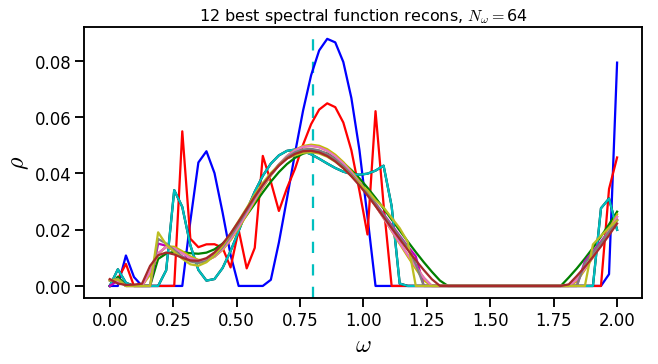

In [20]:
color_table = ['b', 'r', 'g', 'k', 'c', 'y', 'm', 'tab:orange', 'tab:pink', 'tab:gray', 'tab:olive', 'brown']
colors = color_table[:n_best]
with sns.plotting_context('talk'):
    fig, ax = plt.subplots(1, figsize = (10, 5))
    add_line(ax, omega0, color = 'c', dashes = (5, 5), label = '$\\omega_0$')
    for ii in range(n_best):
        plot_1d_function(ax, omega_line, best_rho[ii], colors = [colors[ii]], title = str(n_best) + \
                         ' best spectral function recons, $N_\omega = $' + str(Nomega), \
                         ax_label = ['$\\omega$', '$\\rho$'], legend = False)
#     plt.tight_layout()
#     plt.savefig('/Users/theoares/Dropbox (MIT)/research/spectral/sparse_modeling/tests/test1/param_scan_' \
#                         + str(Nomega) + '.pdf')

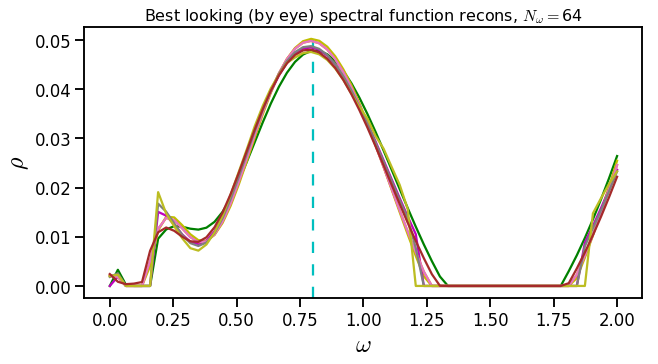

In [21]:
# at the moment, I just want to look at a subset of these because they pass the eye test. However, should add a term 
# in the fidelity function so that these are the ones which are picked out. 
best_recons = [2, 5, 6, 7, 8, 9, 10, 11]    # just look at a subset of them
subcolors = [color_table[ii] for ii in best_recons]
with sns.plotting_context('talk'):
    fig, ax = plt.subplots(1, figsize = (10, 5))
    add_line(ax, omega0, color = 'c', dashes = (5, 5), label = '$\\omega_0$')
    for i, ii in enumerate(best_recons):
        plot_1d_function(ax, omega_line, best_rho[ii], colors = [subcolors[i]], title = \
                         'Best looking (by eye) spectral function recons, $N_\omega = $' + str(Nomega), \
                         ax_label = ['$\\omega$', '$\\rho$'], legend = False)
#     plt.tight_layout()
#     plt.savefig('/Users/theoares/Dropbox (MIT)/research/spectral/sparse_modeling/tests/test1/param_scan_' \
#                         + str(Nomega) + '_best.pdf')

In [22]:
# play with the recons-- why are their primal residuals all so close together?